# Global Green Energy Part 6: Temporal Analysis & Cluster Evolution 📈

This capstone analysis combines temporal correlation analysis with clustering techniques to understand how global energy systems evolve over time. We examine which variables change most systematically with time, apply PCA clustering to recent data, and trace how different country archetypes develop along parallel economic-energy trajectories.

This is Part 6 of a massive 10 part series. 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# load in data
raw_data = pd.read_csv('../data/global_sustainable_energy_data.csv')

#display(raw_data.sample(4))
#raw_data.info()

# data looks good, let's visuailise it. 
df = raw_data.copy()

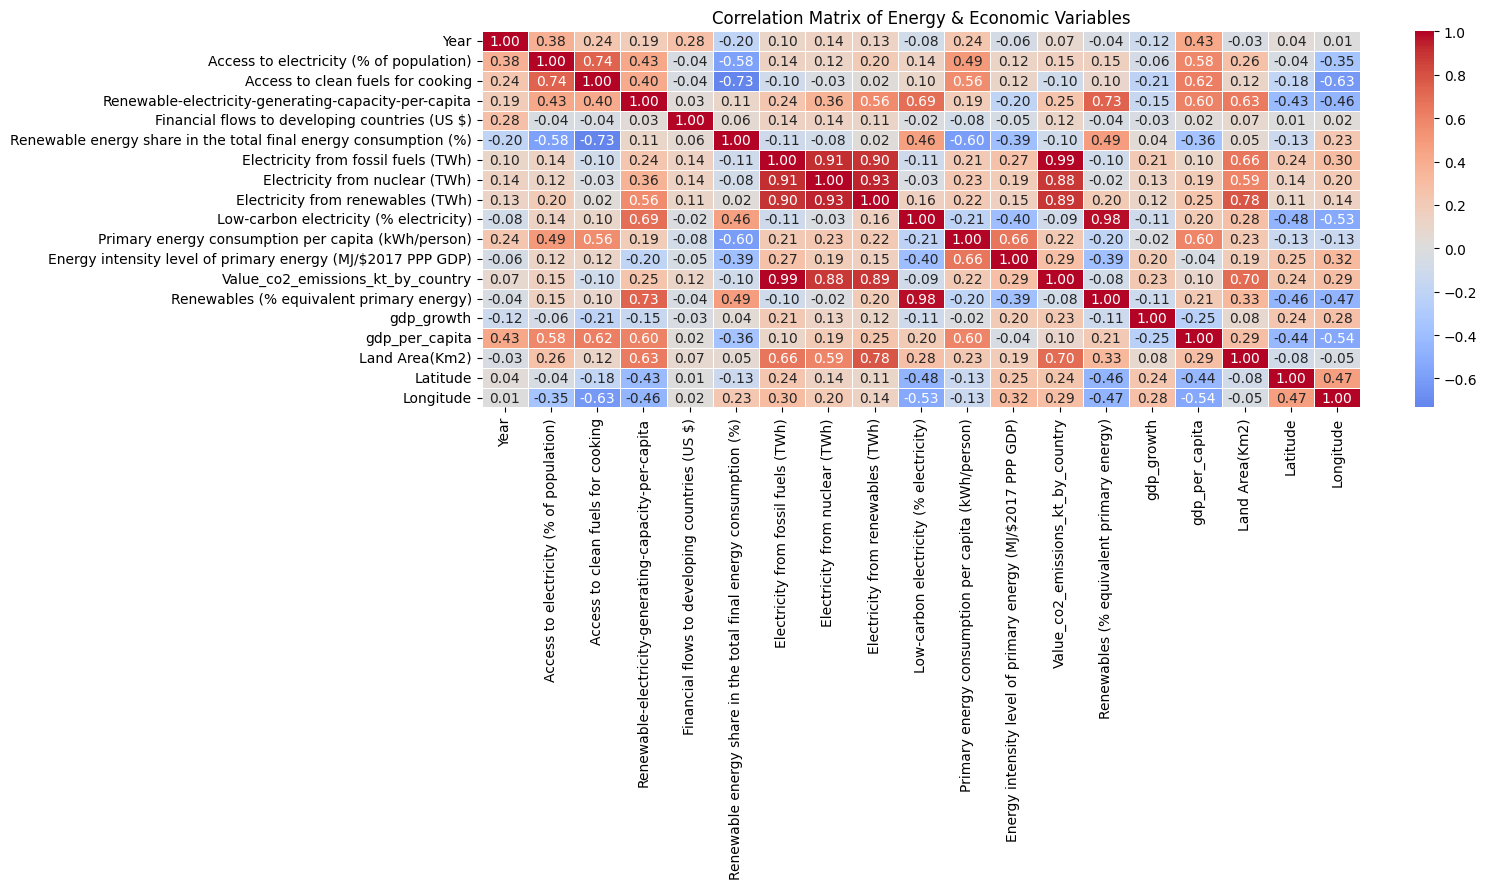

In [35]:
# Select only numeric columns
df_num = df.select_dtypes(include="number")

# Drop missing values (or fillna if needed)
df_corr = df_num.dropna()

# Correlation matrix
corr_matrix = df_corr.corr()

# Plot
plt.figure(figsize=(16, 9))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)
plt.title("Correlation Matrix of Energy & Economic Variables")
plt.tight_layout()
plt.show()

In [36]:
# let's look at what correlates highly with "Year"
df_year_corr = df_corr.corr()['Year'].sort_values(ascending=False)
print(df_year_corr)

Year                                                                1.000000
gdp_per_capita                                                      0.428884
Access to electricity (% of population)                             0.383413
Financial flows to developing countries (US $)                      0.276142
Primary energy consumption per capita (kWh/person)                  0.241667
Access to clean fuels for cooking                                   0.237838
Renewable-electricity-generating-capacity-per-capita                0.192247
Electricity from nuclear (TWh)                                      0.141096
Electricity from renewables (TWh)                                   0.132646
Electricity from fossil fuels (TWh)                                 0.101246
Value_co2_emissions_kt_by_country                                   0.074832
Latitude                                                            0.037926
Longitude                                                           0.006369

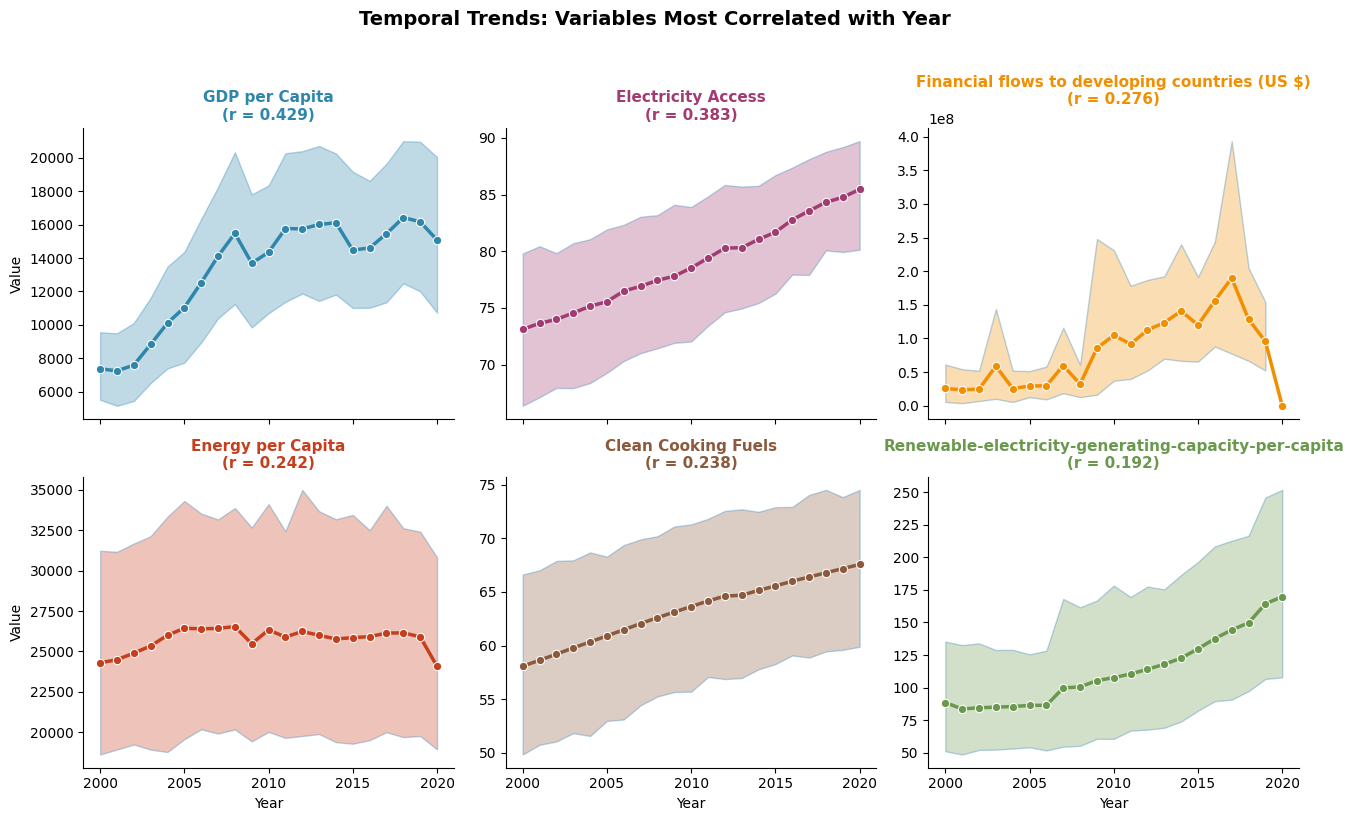

In [37]:
# Step 1: Get top 6 correlating variables (excluding 'Year' itself)
top6_vars = df_year_corr.drop('Year').head(6).index.tolist()

# Step 2: Create a mapping for cleaner variable names
var_name_mapping = {
    'Electricity from fossil fuels (TWh)': 'Fossil Electricity',
    'Electricity from renewables (TWh)': 'Renewable Electricity', 
    'Energy intensity level of primary energy (MJ/$2017 PPP GDP)': 'Energy Intensity',
    'Primary energy consumption per capita (kWh/person)': 'Energy per Capita',
    'Renewables (% equivalent primary energy)': 'Renewable %',
    'Value_co2_emissions_kt_by_country': 'CO2 Emissions',
    'gdp_per_capita': 'GDP per Capita',
    'Access to electricity (% of population)': 'Electricity Access',
    'Access to clean fuels for cooking': 'Clean Cooking Fuels',
    'Land Area(Km2)': 'Land Area'
}

# Step 3: Create color palette
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#8B5A3C', '#6A994E']

# Step 4: Melt the original df to long format
df_melted = df.melt(id_vars='Year', value_vars=top6_vars, var_name='Variable', value_name='Value')

# Step 5: Apply cleaner names
df_melted['Variable'] = df_melted['Variable'].map(var_name_mapping).fillna(df_melted['Variable'])

# Step 6: FacetGrid plot with amendments
g = sns.FacetGrid(df_melted, col='Variable', col_wrap=3, height=4, sharey=False, aspect=1.1)

# Custom mapping function with confidence interval control
def custom_lineplot(x, y, **kwargs):
    sns.lineplot(x=x, y=y, marker='o', linewidth=2.5, 
                errorbar=('ci', 99), **kwargs)  # Reduced CI from 95% to 68%

g.map_dataframe(custom_lineplot, 'Year', 'Value')

# Update titles and colors
for i, (ax, var) in enumerate(zip(g.axes.flat, top6_vars)):
    clean_name = var_name_mapping.get(var, var)
    corr_score = df_year_corr[var]
    color = colors[i % len(colors)]
    
    # Set line color
    ax.lines[0].set_color(color)
    ax.collections[0].set_facecolor(color)  # CI fill color
    ax.collections[0].set_alpha(0.3)  # CI transparency
    
    # Set title with matching color
    ax.set_title(f'{clean_name}\n(r = {corr_score:.3f})', 
                fontweight='bold', fontsize=11, color=color)

g.set_axis_labels('Year', 'Value', fontsize=10)

# Add overall title
g.fig.suptitle('Temporal Trends: Variables Most Correlated with Year', 
               fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()

## 1. Temporal Trends: Variables Most Correlated with Year
This figure presents the six variables with the highest correlation to time over the 2000–2020 period. GDP per capita shows the strongest positive association with year (r = 0.429), rising steadily until the late 2010s before experiencing a slight decline — a pattern reflecting both structural economic growth and recent macroeconomic shocks. Electricity access (r = 0.383) demonstrates a consistent upward trajectory, suggesting broad success in electrification efforts worldwide. 

Financial flows to developing countries (r = 0.276) reveal a more erratic profile, marked by notable spikes and subsequent contractions, indicating dependence on variable external funding cycles. Energy per capita (r = 0.242) has remained relatively flat after early growth, hinting at efficiency gains or demand plateaus. Clean cooking fuels (r = 0.238) have improved gradually, though their lower starting point underscores the slow pace of this critical transition. Renewable electricity capacity per capita (r = 0.192) has grown steadily but from a low base, illustrating that while renewable deployment is expanding, it is not yet the dominant driver of broader energy change.

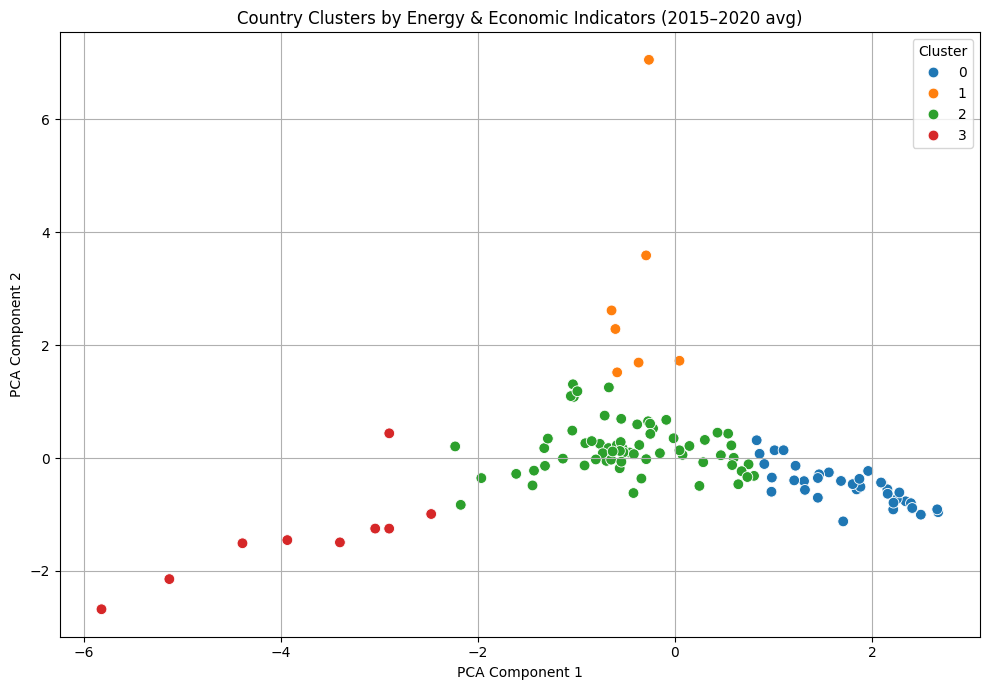

In [38]:
# Define features
features = [
    "gdp_per_capita",
    "Access to electricity (% of population)",
    "Renewable-electricity-generating-capacity-per-capita",
    "Primary energy consumption per capita (kWh/person)",
    "Renewable energy share in the total final energy consumption (%)"
]

# Step 0: Group by country and average over recent years
df_recent = df[df['Year'] >= 2015].copy()
df_cluster = df_recent.groupby('Entity')[features].mean().dropna().reset_index()

# Step 1: Normalize features
X = df_cluster[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
df_cluster['Cluster'] = kmeans.fit_predict(X_scaled)

# Step 3: PCA projection
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
df_cluster['PCA1'] = pca_result[:, 0]
df_cluster['PCA2'] = pca_result[:, 1]

# Step 4: Plot clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_cluster,
    x='PCA1', y='PCA2',
    hue='Cluster',
    palette='tab10',
    s=60
)

plt.title('Country Clusters by Energy & Economic Indicators (2015–2020 avg)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.tight_layout()
plt.show()


## 2. PCA Clusters: Country Groupings by Energy & Economic Indicators
This scatterplot shows countries plotted on the first two principal components derived from a set of energy and economic indicators, averaged over 2015–2020. The PCA transformation compresses complex, correlated variables into two orthogonal axes: the first appears to capture overall development and economic intensity, while the second may reflect differences in energy structure and efficiency. 

The clustering algorithm partitions countries into four distinct groups. Cluster 0 (blue) occupies the high-development end of Component 1, representing advanced economies with high energy access and infrastructure maturity. Cluster 1 (orange) lies between moderate-to-high development but diverges along Component 2, likely reflecting higher renewable penetration or different energy compositions. Cluster 2 (green) spans a broad mid-range, representing countries in transitional stages with diverse energy portfolios. Cluster 3 (red) sits at the low-development end, highlighting economies with constrained energy access and limited renewable adoption. The clear separation between clusters underscores how structural energy–economy relationships differ markedly between these archetypes.

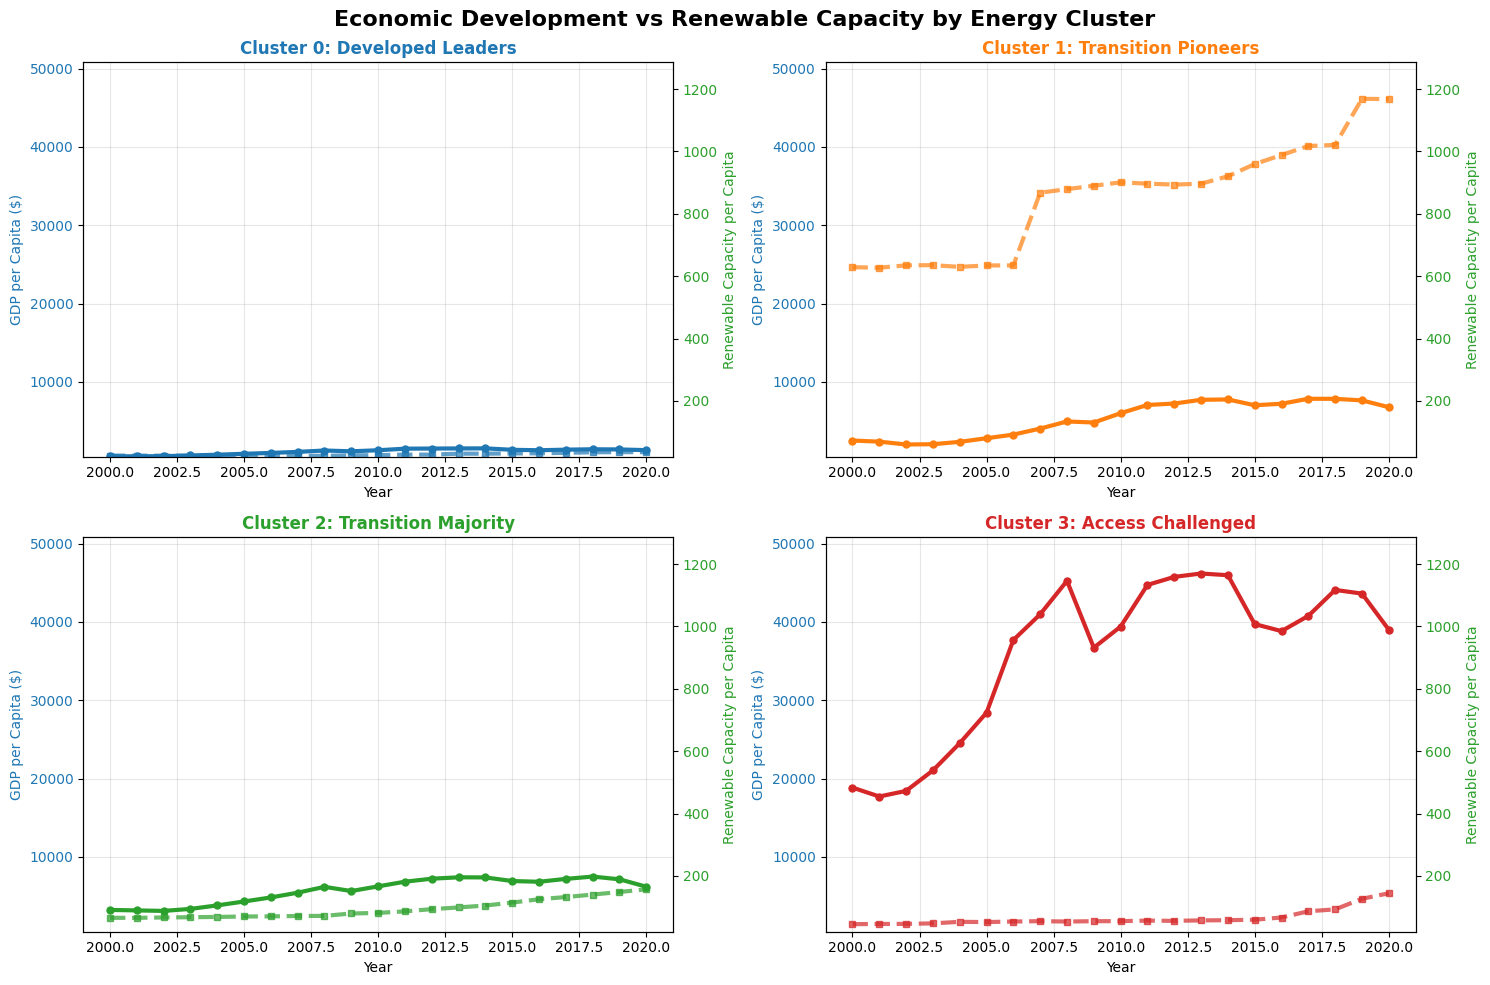

In [42]:
# Merge back cluster labels to full df
df_with_clusters = df.merge(df_cluster[['Entity', 'Cluster']], on='Entity', how='inner')

# Group by year and cluster, then average
df_grouped = df_with_clusters.groupby(['Year', 'Cluster'])[
    ['gdp_per_capita', 'Renewable-electricity-generating-capacity-per-capita']
].mean().reset_index()

# Create 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

# Define colors for consistency
cluster_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
cluster_names = ['Developed Leaders', 'Transition Pioneers', 'Transition Majority', 'Access Challenged']

# Get global min/max for consistent scaling
gdp_min = df_grouped['gdp_per_capita'].min()
gdp_max = df_grouped['gdp_per_capita'].max()
renewable_min = df_grouped['Renewable-electricity-generating-capacity-per-capita'].min()
renewable_max = df_grouped['Renewable-electricity-generating-capacity-per-capita'].max()

# Plot each cluster
for i, cluster in enumerate(sorted(df_grouped['Cluster'].unique())):
    cluster_data = df_grouped[df_grouped['Cluster'] == cluster]
    
    # Create dual axis for this subplot
    ax1 = axes[i]
    ax2 = ax1.twinx()
    
    # GDP line (solid)
    ax1.plot(cluster_data['Year'], cluster_data['gdp_per_capita'], 
             color=cluster_colors[i], linewidth=3, 
             label='GDP per Capita', marker='o', markersize=5)
    
    # Renewable line (dashed)
    ax2.plot(cluster_data['Year'], cluster_data['Renewable-electricity-generating-capacity-per-capita'],
             color=cluster_colors[i], linestyle='--', linewidth=3,
             label='Renewable Capacity', marker='s', markersize=5, alpha=0.7)
    
    # Set consistent scales across all subplots
    ax1.set_ylim(gdp_min * 0.9, gdp_max * 1.1)
    ax2.set_ylim(renewable_min * 0.9, renewable_max * 1.1)
    
    # Labels and styling
    ax1.set_ylabel('GDP per Capita ($)', color='tab:blue', fontsize=10)
    ax2.set_ylabel('Renewable Capacity per Capita', color='tab:green', fontsize=10)
    ax1.set_xlabel('Year', fontsize=10)
    
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:green')
    
    ax1.grid(True, alpha=0.3)
    ax1.set_title(f'Cluster {cluster}: {cluster_names[i]}', 
                  fontweight='bold', fontsize=12, color=cluster_colors[i])

plt.suptitle('Economic Development vs Renewable Capacity by Energy Cluster', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

## 3. Cluster-Specific Trends: GDP and Renewable Capacity
This panel of plots tracks GDP per capita (solid lines, left axis) and renewable electricity capacity per capita (dashed lines, right axis) from 2000 to 2020 for each PCA cluster. Cluster 0 (Developed Leaders) shows stable, high GDP with incremental renewable growth, reflecting saturated markets and steady policy-driven capacity expansion. Cluster 1 (Transition Pioneers) demonstrates both rising GDP and a strong, sustained increase in renewable capacity, suggesting active transition strategies and effective policy frameworks.

Cluster 2 (Transition Majority) presents moderate GDP growth with a gradual but slower renewable capacity increase, indicative of incremental improvements without large-scale transformation. Cluster 3 (Access Challenged) exhibits persistently low renewable capacity despite some GDP growth spurts — often driven by short-term economic events rather than sustained development. The contrast between clusters highlights that renewable adoption is not solely a function of economic growth; institutional capacity, policy choices, and infrastructure readiness play decisive roles.

## Concluding Remarks
The three analyses collectively reveal a layered story: global progress in energy and economic metrics is real but uneven, with country trajectories diverging sharply depending on structural starting points. The temporal trends show which metrics are improving globally, the PCA clustering provides a typology of energy–economy profiles, and the cluster-specific trends demonstrate how those profiles translate into real-world development and renewable adoption patterns.

This combined approach points toward the need for archetype-specific strategies. Developed leaders can focus on deep decarbonization and innovation; transition pioneers should consolidate renewable gains; the transition majority requires targeted investment to accelerate change; and access-challenged countries need foundational infrastructure and enabling policy frameworks to bridge the gap.